## Project description:

Online shops have exact same items that are sold by multiple people. ML could help in order to group them.

In Kaggle competition [Shopee - Price Match Guarantee](https://www.kaggle.com/c/shopee-product-matching/overview) there are two item features provided: image and description.

Submission file has to include up to 50 best matches from train dataset for every test item.

Evaluation: mean F1

-----------

#### Planned approach in general

1. With pre-trained NLP model extract probabilities of described items
2. With pre-trained NN model extract probabilities of shown items
3. Build AND gate that include both models threshold

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier

from imblearn.over_sampling import RandomOverSampler

from functools import partial

import time

import io
import os

RANDOM = 777

%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [3]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

<IPython.core.display.Javascript object>

## EDA

**General info**

In [4]:
train_df.head()

,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069


<IPython.core.display.Javascript object>

In [5]:
train_df.shape

(34250, 5)

<IPython.core.display.Javascript object>

In [6]:
test_df.head()

,posting_id,image,image_phash,title
0,test_2255846744,0006c8e5462ae52167402bac1c2e916e.jpg,ecc292392dc7687a,Edufuntoys - CHARACTER PHONE ada lampu dan mus...
1,test_3588702337,0007585c4d0f932859339129f709bfdc.jpg,e9968f60d2699e2c,(Beli 1 Free Spatula) Masker Komedo | Blackhea...
2,test_4015706929,0008377d3662e83ef44e1881af38b879.jpg,ba81c17e3581cabe,READY Lemonilo Mie instant sehat kuah dan goreng


<IPython.core.display.Javascript object>

**Label distribution**

In [7]:
train_df.label_group.nunique()

11014

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='label_group'>

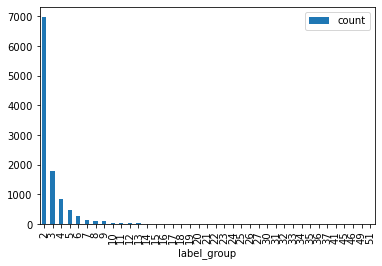

<IPython.core.display.Javascript object>

In [8]:
val_counts = train_df.label_group.value_counts()
value_df = pd.DataFrame(val_counts)
value_df["count"] = 1
value_df.groupby("label_group").sum().plot(kind="bar")

The vast majority of products have only 2 representatives of them in train dataset.

## NLP approach

**Preprocessing**

In [87]:
# extracting text and labels for train and test datasets
train_text = train_df.title.values
test_text = test_df.title.values
train_labels = train_df.label_group.values
train_ids = train_df.posting_id.values

<IPython.core.display.Javascript object>

In [88]:
# label encoding
le = LabelEncoder()
train_ids = le.fit_transform(train_ids)

<IPython.core.display.Javascript object>

In [89]:
# initializing vectorizer
vectorizer = TfidfVectorizer(stop_words=["english", "indonesian"], binary=True)

<IPython.core.display.Javascript object>

In [90]:
# vectorizing text in train and test datasets
train_text_vectorized = vectorizer.fit_transform(train_text)
test_text_vectorized = vectorizer.transform(test_text)

<IPython.core.display.Javascript object>

In [102]:
# initializing and training KNN classifier

knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(train_text_vectorized, train_ids)

# predicting and transforming label to label_group
preds = knn.kneighbors(test_text_vectorized, n_neighbors=10, return_distance=False)

<IPython.core.display.Javascript object>

In [103]:
preds

array([[ 4016, 24700, 15744,  7727,  8678,  6109, 15481,  8566, 13471,
        29986],
       [ 5551,  8464, 10375, 22195, 19472, 14081, 26890,  1514, 32243,
        14253],
       [ 7051, 20450, 33889, 11967, 23980, 20232, 12130, 26469, 18133,
        18686]], dtype=int64)

<IPython.core.display.Javascript object>

In [104]:
def preds_to_csv(pred: list, csv_name: str) -> pd.DataFrame:
    """Function will screen train df based on predicted label_group and generate submission dataframe"""
    sub_df = test_df[["posting_id", "image_phash"]].copy()
    sub_df.columns = ["posting_id", "matches"]
    for i in range(3):
        sub_df.iloc[i, 1] = str(sub_df.iloc[i, 0])
        for post_id in le.inverse_transform(preds[i]).tolist():
            sub_df.iloc[i, 1] += f", {post_id}"
    sub_df.to_csv(csv_name + ".csv", index=False)
    return sub_df

<IPython.core.display.Javascript object>

In [105]:
submission = preds_to_csv(preds, "sub3")

<IPython.core.display.Javascript object>

In [106]:
submission["matches"].values

array(['test_2255846744, train_144945394, train_3789725061, train_2762621815, train_1862234356, train_196432360, train_1683604570, train_2730700012, train_1952616317, train_2504152429, train_518561022',
       'test_3588702337, train_1623971378, train_1941882643, train_2150903810, train_3504902322, train_3183212741, train_2575535577, train_40365697, train_1164304703, train_77356149, train_2596033311',
       'test_4015706929, train_1789518874, train_3297964086, train_959095645, train_2332554765, train_3709532605, train_3270819794, train_2349344461, train_3988349948, train_3036323937, train_3093956082'],
      dtype=object)

<IPython.core.display.Javascript object>